# 1. Libraries


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import joblib

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 2. Loading dataset

In [11]:
data = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")
data.head()

,date_time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
0,2022-10-01 07:00:00,25.511000,94.49476,24.561,31.543438,1.3,100.0,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
1,2022-10-01 08:00:00,26.411001,88.26100,24.311,31.320229,0.6,100.0,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2,2022-10-01 09:00:00,26.911001,88.03870,24.761,32.211530,0.7,100.0,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
3,2022-10-01 10:00:00,28.011000,85.29904,25.311,33.920822,0.6,100.0,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
4,2022-10-01 11:00:00,29.011000,78.12226,24.811,34.491055,0.4,100.0,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


# 3. EDA

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_time                17544 non-null  object 
 1   temperature_2m           17544 non-null  float64
 2   relative_humidity_2m     17544 non-null  float64
 3   dew_point_2m             17544 non-null  float64
 4   apparent_temperature     17544 non-null  float64
 5   precipitation            17544 non-null  float64
 6   cloud_cover              17544 non-null  float64
 7   vapour_pressure_deficit  17544 non-null  float64
 8   wind_speed_10m           17544 non-null  float64
 9   wind_direction_10m       17544 non-null  float64
 10  pm10                     17544 non-null  float64
 11  pm2_5                    17544 non-null  float64
 12  carbon_monoxide          17544 non-null  float64
 13  nitrogen_dioxide         17544 non-null  float64
 14  sulphur_dioxide       

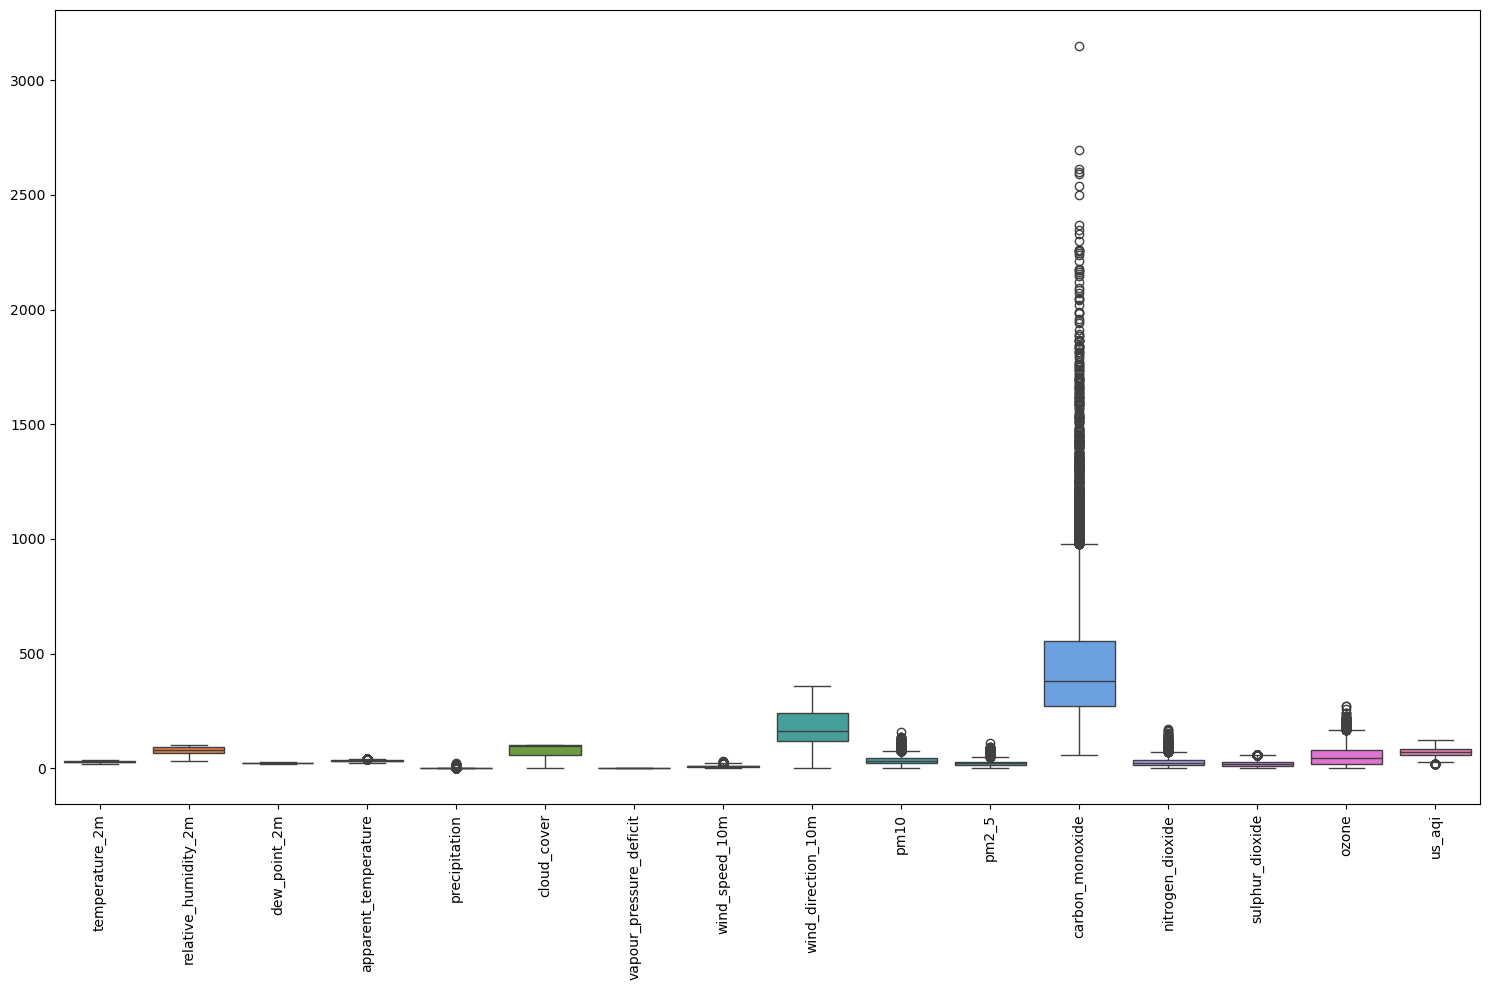

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=data.drop(columns=['date_time', 'weather_status']))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. General preprocessing dataset

## 0. Preprocessing date_time 

In [14]:
target = 'us_aqi'

data['date_time'] = pd.to_datetime(data['date_time'])
data.set_index('date_time', inplace=True)

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X



## 1. Scale numeric features

In [15]:
numeric_features = [col for col in data.columns if data[col].dtype != 'object' and col != target]

std_scaler = StandardScaler()
robust_scaler = RobustScaler()

robust_scaled_data = data.copy()
std_scaled_data = data.copy()

robust_scaled_data[numeric_features] = robust_scaler.fit_transform(robust_scaled_data[numeric_features])
std_scaled_data[numeric_features] = std_scaler.fit_transform(std_scaled_data[numeric_features])

scaled_data = std_scaled_data.copy()
scaled_data.head()


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
date_time,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,-0.707377,1.035719,0.687277,-0.204351,0.959470,0.676128,-0.940007,-1.265070,0.348822,1.541658,1.581827,2.629139,1.260873,-0.693860,-1.193231,73.652490,Light Rain
2022-10-01 08:00:00,-0.418294,0.653450,0.574224,-0.270232,0.313040,0.676128,-0.650646,0.148402,0.602837,0.111548,0.122975,1.783882,0.828115,-0.712200,-0.949673,76.471634,Moderate Drizzle
2022-10-01 09:00:00,-0.257692,0.639818,0.777719,-0.007163,0.405387,0.676128,-0.624972,-0.004799,0.406897,-0.412237,-0.419853,0.584162,0.208294,-0.737876,-0.633048,77.597520,Moderate Drizzle
2022-10-01 10:00:00,0.095631,0.471815,1.026436,0.497337,0.313040,0.676128,-0.455189,-0.372165,0.182794,-0.635875,-0.640377,-0.650615,-0.475742,-0.767220,-0.121576,78.182625,Moderate Drizzle
2022-10-01 11:00:00,0.416834,0.031717,0.800330,0.665642,0.128346,0.676128,-0.041698,-0.226199,0.260908,-0.529941,-0.538597,-0.915488,-0.780068,-0.767220,0.341184,78.430855,Light Drizzle


## 2. Encoding 'weather_status'

In [ ]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# One-hot encode the 'weather_status' column
encoded_feature = encoder.fit_transform(scaled_data[['weather_status']])

# Get column names for encoded features
encoded_col_names = encoder.get_feature_names_out(['weather_status'])

# Create a DataFrame for the encoded features with proper column names
encoded_feature_df = pd.DataFrame(encoded_feature, columns=encoded_col_names, index=scaled_data.index)

# Concatenate the encoded features with the rest of the data
encoded_data = pd.concat([scaled_data.drop(columns=["weather_status"]), encoded_feature_df], axis=1)

encoded_data.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,...,us_aqi,weather_status_Dense Drizzle,weather_status_Heavy Rain,weather_status_Light Drizzle,weather_status_Light Rain,weather_status_Mainly Clear,weather_status_Moderate Drizzle,weather_status_Moderate Rain,weather_status_Overcast,weather_status_Partly Cloudy
date_time,,,,,,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,-0.707377,1.035719,0.687277,-0.204351,0.959470,0.676128,-0.940007,-1.265070,0.348822,1.541658,...,73.652490,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-01 08:00:00,-0.418294,0.653450,0.574224,-0.270232,0.313040,0.676128,-0.650646,0.148402,0.602837,0.111548,...,76.471634,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 09:00:00,-0.257692,0.639818,0.777719,-0.007163,0.405387,0.676128,-0.624972,-0.004799,0.406897,-0.412237,...,77.597520,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 10:00:00,0.095631,0.471815,1.026436,0.497337,0.313040,0.676128,-0.455189,-0.372165,0.182794,-0.635875,...,78.182625,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-10-01 11:00:00,0.416834,0.031717,0.800330,0.665642,0.128346,0.676128,-0.041698,-0.226199,0.260908,-0.529941,...,78.430855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
preproc_data = encoded_data
other_features = [col for col in preproc_data.columns if col != target]

# 4. Training models

## 0. Prepare saving path

In [ ]:
import os

model_save_path = '../model2/'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

## 1. ARIMA

In [ ]:
arima_data = preproc_data[target]
arima_data = arima_data.asfreq('h')

train_size = int(len(arima_data) * 0.8)
train, test = arima_data[:train_size], arima_data[train_size:]

arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()

arima_forecast = arima_result.forecast(steps=len(test))
arima_mse = mean_squared_error(test, arima_forecast)

joblib.dump(arima_result, model_save_path + "arima_model.pkl")
print(f"ARIMA MSE: {arima_mse}")

/home/van/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA MSE: 530.886326990705


In [ ]:
from pmdarima import auto_arima

# Tuning ARIMA
arima_model = auto_arima(
    train,
    start_p=0, max_p=5,       # Giá trị p
    start_q=0, max_q=5,       # Giá trị q
    d=None,                   # Tự động xác định d
    seasonal=False,           # ARIMA không có thành phần mùa vụ
    trace=True,               # In ra quá trình tìm kiếm
    error_action='ignore',    # Bỏ qua lỗi
    suppress_warnings=True,   # Tắt cảnh báo
    stepwise=True             # Sử dụng chiến lược tìm kiếm stepwise
)


In [ ]:
print(arima_model.summary())
forecast = arima_model.predict(n_periods=len(test))
print(f"ARIMA MSE: {mean_squared_error(test, forecast)}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                14035
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -13088.942
Date:                Mon, 02 Dec 2024   AIC                          26193.884
Time:                        19:54:02   BIC                          26254.277
Sample:                    10-01-2022   HQIC                         26213.987
                         - 05-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3909      0.014     27.672      0.000       0.363       0.419
ar.L2         -0.6020      0.011    -55.930      0.000      -0.623      -0.581
ar.L3          0.7057      0.008     89.952      0.0

## 2. SARIMA

In [ ]:
sarima_data = preproc_data[target].asfreq('h')

train_size = int(len(sarima_data) * 0.8)
train, test = sarima_data[:train_size], arima_data[train_size:]

sarima_model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 24)) 
sarima_result = sarima_model.fit()

sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_mse = mean_squared_error(test, sarima_forecast)

joblib.dump(sarima_result, model_save_path + "sarima_model.pkl")
print(f"SARIMA MSE: {sarima_mse}")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13734D+00    |proj g|=  4.65661D-01

At iterate    5    f=  9.79529D-01    |proj g|=  7.43844D-02

At iterate   10    f=  9.27689D-01    |proj g|=  1.48390D-02

At iterate   15    f=  9.22592D-01    |proj g|=  3.91346D-02

At iterate   20    f=  9.22118D-01    |proj g|=  1.06145D-03

At iterate   25    f=  9.22090D-01    |proj g|=  4.03058D-04

At iterate   30    f=  9.22087D-01    |proj g|=  1.35262D-03

At iterate   35    f=  9.22086D-01    |proj g|=  9.82630D-05

At iterate   40    f=  9.22086D-01    |proj g|=  1.25923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

## 3. Random Forest Regressor

In [ ]:
data = preproc_data.copy()
for lag in range(1, 13):
    data[f'us_aqi_lag_{lag}'] = data[target].shift(lag)
data.dropna(inplace=True)

X = data[[f'us_aqi_lag_{i}' for i in range(1, 13)] + other_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_forecast = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_forecast)
rf_r2 = r2_score(y_test, rf_forecast)


# joblib.dump(rf_model, model_save_path + "random_forest_model.pkl")
print(f"Random Forest MSE: {rf_mse}")

Random Forest MSE: 0.18271149620825064


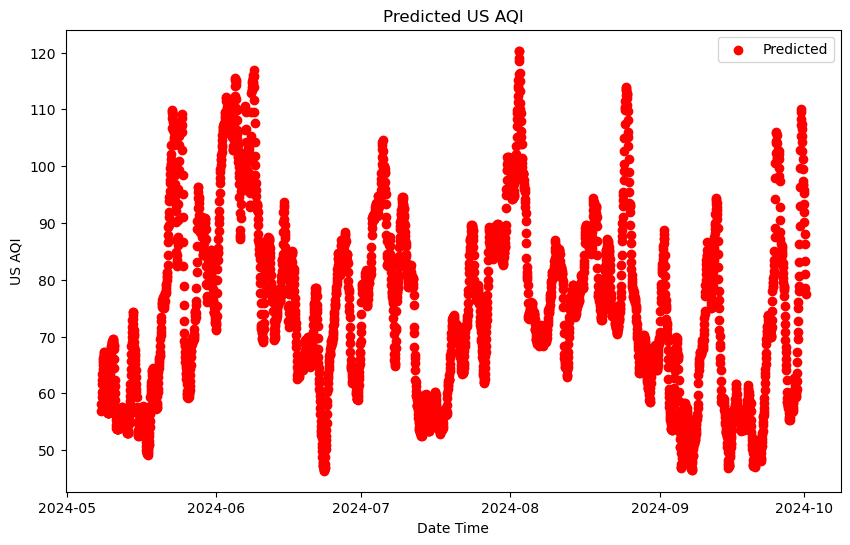

In [ ]:
# Plot predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, rf_forecast, color='red', label='Predicted')
plt.xlabel('Date Time')
plt.ylabel('US AQI')
plt.title('Predicted US AQI')
plt.legend()
plt.show()

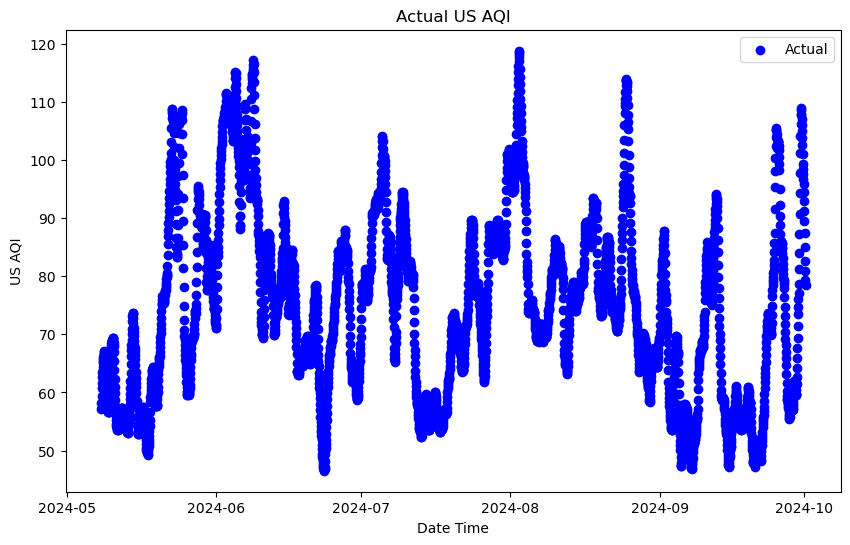

In [ ]:
# Plot actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', label='Actual')
plt.xlabel('Date Time')
plt.ylabel('US AQI')
plt.title('Actual US AQI')
plt.legend()
plt.show()

## 4. XGBoost Regressor

In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor()
xgb.fit(X_train_xgb, y_train_xgb)
xgb_predictions = xgb.predict(X_test_xgb)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

joblib.dump(xgb, model_save_path + "xgboost_model.pkl")
print(f"XGBoost MSE: {xgb_mse}")

XGBoost MSE: 648.6787034150469


[0]	validation_0-rmse:17.73914
[1]	validation_0-rmse:15.98094
[2]	validation_0-rmse:14.40197
[3]	validation_0-rmse:12.97754
[4]	validation_0-rmse:11.69484
[5]	validation_0-rmse:10.54328
[6]	validation_0-rmse:9.50516
[7]	validation_0-rmse:8.56885
[8]	validation_0-rmse:7.72562
[9]	validation_0-rmse:6.96651
[10]	validation_0-rmse:6.28548
[11]	validation_0-rmse:5.67097
[12]	validation_0-rmse:5.12280
[13]	validation_0-rmse:4.62707
[14]	validation_0-rmse:4.18901
[15]	validation_0-rmse:3.79284
[16]	validation_0-rmse:3.43282
[17]	validation_0-rmse:3.10779
[18]	validation_0-rmse:2.81664
[19]	validation_0-rmse:2.55433
[20]	validation_0-rmse:2.31946
[21]	validation_0-rmse:2.10942
[22]	validation_0-rmse:1.92257
[23]	validation_0-rmse:1.75547
[24]	validation_0-rmse:1.60538
[25]	validation_0-rmse:1.47562
[26]	validation_0-rmse:1.36181
[27]	validation_0-rmse:1.25651
[28]	validation_0-rmse:1.16442
[29]	validation_0-rmse:1.08239
[30]	validation_0-rmse:1.01281
[31]	validation_0-rmse:0.95109
[32]	validat

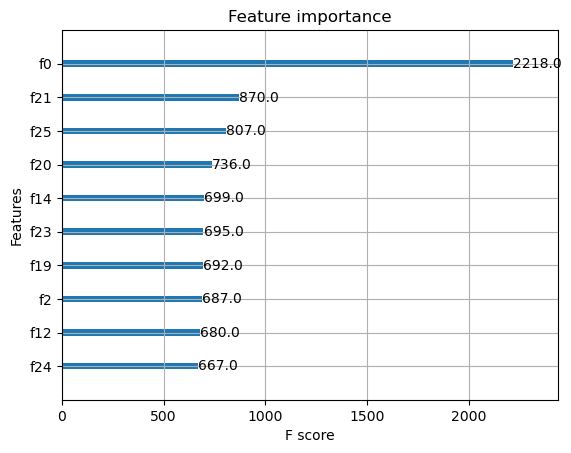

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_importance
from joblib import dump
import matplotlib.pyplot as plt
import os

# Chia tập dữ liệu
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_xgb = scaler.fit_transform(X_train_xgb)
X_test_xgb = scaler.transform(X_test_xgb)

# Khởi tạo và huấn luyện mô hình
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_xgb, y_train_xgb, eval_set=[(X_test_xgb, y_test_xgb)], verbose=True)

# Dự đoán và đánh giá
xgb_predictions = xgb.predict(X_test_xgb)
xgb_mse = mean_squared_error(y_test_xgb, xgb_predictions)
xgb_mae = mean_absolute_error(y_test_xgb, xgb_predictions)
xgb_r2 = r2_score(y_test_xgb, xgb_predictions)

print(f"XGBoost MSE: {xgb_mse}")
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost R²: {xgb_r2}")

# Lưu mô hình
model_path = os.path.join(model_save_path, "xgboost_model.pkl")
dump(xgb, model_path)
print(f"Model saved at {model_path}")

# Hiển thị feature importance
plot_importance(xgb, max_num_features=10)
plt.show()


## 6. Testing results

In [ ]:
results = {
    "ARIMA": arima_mse,
    "SARIMA": sarima_mse,
    "Random Forest": rf_mse,
    "XGBoost": xgb_mse,
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df.to_csv("model_results.csv")
print(results_df)

                      MSE
ARIMA          541.790173
SARIMA         610.636716
Random Forest    0.183203
XGBoost        648.550820
LSTM           745.236969
